In [1]:
import os
import time
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from tensorflow import keras
kl_loss=0

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')
x_test = x_test.astype('float32')
#x_train = x_train / 255.
x_test = x_test / 255.
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).\
shuffle(60000).batch(128)

4422102/4422102 [==============================] - 0s 0us/step


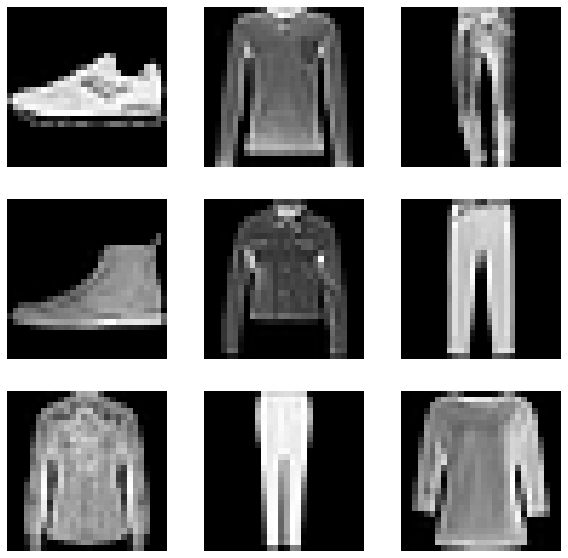

In [3]:
plt.figure(figsize=(10, 10))
for images in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i,:,:,0].numpy().astype("uint8"), cmap='gray')
        plt.axis("off")

In [4]:
normalization_layer = layers.experimental.preprocessing.Rescaling(scale= 1./255)

In [5]:
normalized_ds = train_dataset.map(lambda x: normalization_layer(x))
image_batch = next(iter(normalized_ds))
first_image = image_batch[0]

In [6]:
input_encoder = (28, 28, 1)
input_decoder = (2,)

In [7]:
def sampling_model(distribution_params):
    mean, log_var = distribution_params
    epsilon = K.random_normal(shape=K.shape(mean), mean=0., stddev=1.)
    print(epsilon)
    return mean + K.exp(log_var / 2) * epsilon

In [8]:
sampling_model

<function __main__.sampling_model(distribution_params)>

In [9]:
def encoder(input_encoder):
    
    inputs = keras.Input(shape=input_encoder, name='input_layer')
    x = layers.Conv2D(32, kernel_size=3, strides= 1, padding='same', name='conv_1')(inputs)
    x = layers.BatchNormalization(name='bn_1')(x)
    x = layers.LeakyReLU(name='lrelu_1')(x)
    
    
    x = layers.Conv2D(64, kernel_size=3, strides= 2, padding='same', name='conv_2')(x)
    x = layers.BatchNormalization(name='bn_2')(x)
    x = layers.LeakyReLU(name='lrelu_2')(x)
    
    
    x = layers.Conv2D(64, 3, 2, padding='same', name='conv_3')(x)
    x = layers.BatchNormalization(name='bn_3')(x)
    x = layers.LeakyReLU(name='lrelu_3')(x)
  

    x = layers.Conv2D(64, 3, 1, padding='same', name='conv_4')(x)
    x = layers.BatchNormalization(name='bn_4')(x)
    x = layers.LeakyReLU(name='lrelu_4')(x)
   
    
    flatten = layers.Flatten()(x)
    mean = layers.Dense(2, name='mean')(flatten)
    log_var = layers.Dense(2, name='log_var')(flatten)
    model = tf.keras.Model(inputs, (mean, log_var), name="Encoder")
    return model

In [10]:
enc = encoder(input_encoder)

In [11]:
enc.output

(<KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'mean')>,
 <KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'log_var')>)

In [12]:
# enc.save('vae-fashion-enc.h5')

In [13]:
input_1 = (2,)
input_2 = (2,)

In [14]:
def sampling(input_1,input_2):
    #input1 = layers.Lambda(sampling_model, name='encoder_output')([mean, var])
    mean = keras.Input(shape=input_1, name='input_layer1')
    log_var = keras.Input(shape=input_2, name='input_layer2')
    out = layers.Lambda(sampling_model, name='encoder_output')([mean, log_var])
    enc_2 = tf.keras.Model([mean,log_var], out,  name="Encoder_2")
    return enc_2

In [15]:
final = sampling(input_1,input_2)

Tensor("encoder_output/random_normal:0", shape=(None, 2), dtype=float32)


In [16]:
# final.save('sampling.h5')

In [17]:
def decoder(input_decoder):
    
    inputs = keras.Input(shape=input_decoder, name='input_layer')
    x = layers.Dense(3136, name='dense_1')(inputs)
    x = layers.Reshape((7, 7, 64), name='Reshape_Layer')(x)
   
    # Block-1
    x = layers.Conv2DTranspose(64, 3, strides= 1, padding='same',name='conv_transpose_1')(x)
    x = layers.BatchNormalization(name='bn_1')(x)
    x = layers.LeakyReLU(name='lrelu_1')(x)
  
    # Block-2
    x = layers.Conv2DTranspose(64, 3, strides= 2, padding='same', name='conv_transpose_2')(x)
    x = layers.BatchNormalization(name='bn_2')(x)
    x = layers.LeakyReLU(name='lrelu_2')(x)
    
    # Block-3
    x = layers.Conv2DTranspose(32, 3, 2, padding='same', name='conv_transpose_3')(x)
    x = layers.BatchNormalization(name='bn_3')(x)
    x = layers.LeakyReLU(name='lrelu_3')(x)
    
    # Block-4
    outputs = layers.Conv2DTranspose(1, 3, 1,padding='same', activation='sigmoid', name='conv_transpose_4')(x)
    model = tf.keras.Model(inputs, outputs, name="Decoder")
    return model

In [18]:
dec = decoder(input_decoder)

In [19]:
# dec.save('vae-fashion-dec.h5')

In [20]:
optimizer = tf.keras.optimizers.Adam(lr = 0.0005)

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [21]:
def mse_loss(y_true, y_pred):
    r_loss = K.mean(K.square(y_true - y_pred), axis = [1,2,3])
    return 1000 * r_loss

def kl_loss(mean, log_var):
    kl_loss2 =  -0.5 * K.sum(1 + log_var - K.square(mean) - K.exp(log_var), axis = 1)
    return kl_loss2

def vae_loss(y_true, y_pred, mean, log_var):
    r_loss = mse_loss(y_true, y_pred)
    kl_loss3 = kl_loss(mean, log_var)
    return  r_loss + kl_loss3

In [22]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):

    with tf.GradientTape() as encoder, tf.GradientTape() as decoder:
      
        mean, log_var = enc(images, training=True)
        latent = final([mean, log_var])
        generated_images = dec(latent, training=True)
        loss = vae_loss(images, generated_images, mean, log_var)

        
    gradients_of_enc = encoder.gradient(loss, enc.trainable_variables)
    gradients_of_dec = decoder.gradient(loss, dec.trainable_variables)
    
    
    optimizer.apply_gradients(zip(gradients_of_enc, enc.trainable_variables))
    optimizer.apply_gradients(zip(gradients_of_dec, dec.trainable_variables))
    return loss

In [23]:
os.makedirs('tf_vae/fashion/training_weights', exist_ok=True)
os.makedirs('tf_vae/fashion/images', exist_ok=True)

In [24]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        i = 0
        loss_ = []
        for image_batch in dataset:
            i += 1
            loss = train_step(image_batch)
            #loss_.append(loss)

        #print("Loss",np.mean(loss_))    
        seed = image_batch[:25]
        display.clear_output(wait=True)
        generate_and_save_images([enc,final,dec],
                                  epoch + 1,
                                  seed)
        # Save the model every 15 epochs
        #if (epoch + 1) % 15 == 0:
        #checkpoint.save(file_prefix = checkpoint_prefix)
        enc.save_weights('tf_vae/fashion/training_weights/enc_'+ str(epoch)+'.h5')
        dec.save_weights('tf_vae/fashion/training_weights/dec_'+ str(epoch)+'.h5')
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

        # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images([enc,final,dec],
                            epochs,
                            seed)

In [25]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
    m, v = enc(test_input, training=False)
    latent = final([m,  v])
    predictions = dec(latent, training=False)
    print(predictions.shape)
    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(5, 5, i+1)
        plt.imshow(predictions[i, :, :, 0] * 255, cmap='gray')
        plt.axis('off')

    plt.savefig('tf_vae/fashion/images/image_at_epoch_{:d}.png'.format(epoch))
    plt.show()

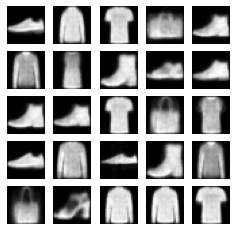

In [ ]:
train(normalized_ds, 100)

In [ ]:
enc.load_weights('tf_vae/fashion/training_weights/enc_99.h5')
dec.load_weights('tf_vae/fashion/training_weights/dec_99.h5')

## Latent Space Projection of Variational Autoencoder Trained on Fashion-MNIST

157/157 [==============================] - 0s 2ms/step
tf.Tensor(
[[-0.4593339   0.3729792 ]
 [ 0.8248424   1.7828245 ]
 [-0.5743024  -0.04851906]
 ...
 [-0.39225513 -1.397487  ]
 [-1.9701252  -0.28005686]
 [ 0.16075392 -0.9736833 ]], shape=(5000, 2), dtype=float32)


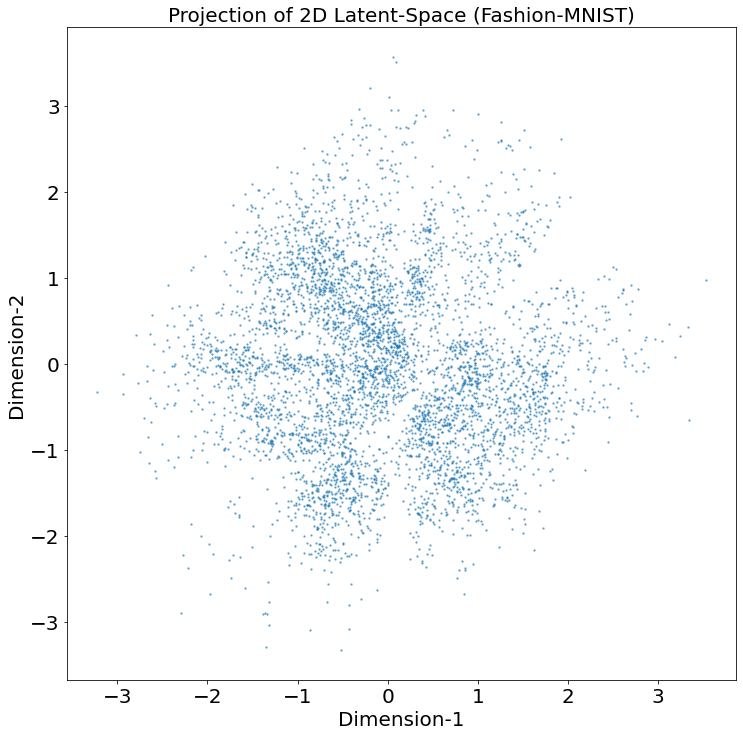

In [ ]:
n_to_show = 5000
figsize = 12

example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx]

m, v = enc.predict(example_images)
embeddings = final([m,v])



plt.figure(figsize=(figsize, figsize))
plt.scatter(embeddings[:, 0] , embeddings[:, 1], alpha=0.5, s=2)
plt.xlabel("Dimension-1", size=20)
plt.ylabel("Dimension-2", size=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.title("Projection of 2D Latent-Space (Fashion-MNIST)", size=20)
plt.show()

In [ ]:
# Create dictionary of target classes
label_dict = {
 0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot',
}

## Reconstructing Fashion Images with Latent-Vector Sampled from Normal Distribution

1/1 [==============================] - 0s 154ms/step


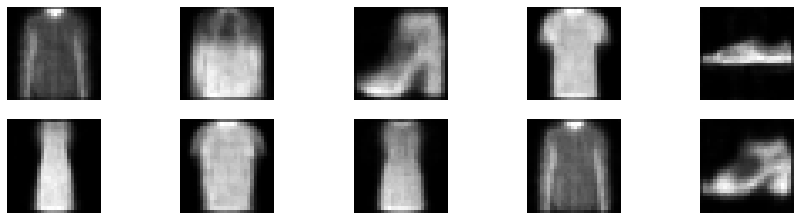

In [ ]:
figsize = 15

x = np.random.normal(size = (10,2))
#x = np.random.uniform(size = (10,200))
reconstruct = dec.predict(x)


fig = plt.figure(figsize=(figsize, 10))

for i in range(10):
    ax = fig.add_subplot(5, 5, i+1)
    ax.axis('off')
    ax.imshow(reconstruct[i, :,:,0]*255, cmap = 'gray')

## Reconstructing Test Images

1/1 [==============================] - 0s 14ms/step
tf.Tensor(
[[-1.4213275   0.1919295 ]
 [ 0.6281471   0.10009593]
 [-1.1321278  -0.15350835]
 [-0.3276524  -0.37530228]
 [ 0.230893   -0.28210104]
 [-0.9744258  -0.78633624]
 [-1.0897175  -1.2177423 ]
 [ 0.61900306 -0.76008475]
 [ 0.25657952 -0.983238  ]
 [ 1.7875642   0.3025584 ]
 [ 0.24302718  0.86754316]
 [ 0.23821963  1.5132442 ]
 [ 0.01701495 -1.0615754 ]
 [ 1.3190193  -0.15479153]
 [ 0.32171404  0.7258706 ]
 [-0.00528281 -1.1786327 ]
 [-0.17321168  1.1627187 ]
 [ 0.02820817 -0.48649582]
 [ 1.5977598  -1.4195784 ]
 [-1.0383445  -1.3488458 ]
 [ 0.4737068   0.71958923]
 [-0.05515309 -0.15102516]
 [ 1.3796862  -0.25948295]
 [ 1.5442889  -0.3090568 ]
 [-1.264535   -0.4337794 ]], shape=(25, 2), dtype=float32)
1/1 [==============================] - 0s 12ms/step


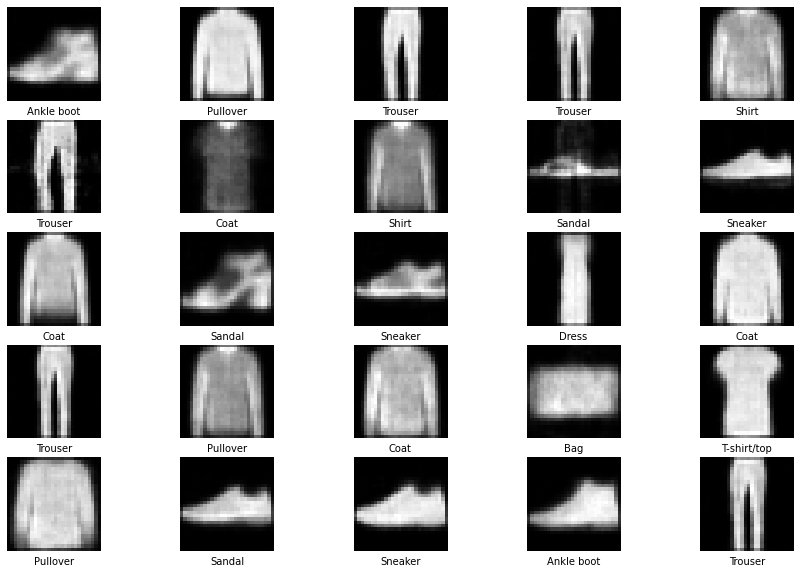

In [ ]:
figsize = 15

m, v = enc.predict(x_test[:25])
latent = final([m,v])
reconst = dec.predict(latent)

fig = plt.figure(figsize=(figsize, 10))

for i in range(25):
    ax = fig.add_subplot(5, 5, i+1)
    ax.axis('off')
    ax.text(0.5, -0.15, str(label_dict[y_test[i]]), fontsize=10, ha='center', transform=ax.transAxes)
    
    ax.imshow(reconst[i, :,:,0]*255, cmap = 'gray')

## Reconstructing Fashion Images with Latent-Vector Sampled Uniformly

1/1 [==============================] - 0s 15ms/step


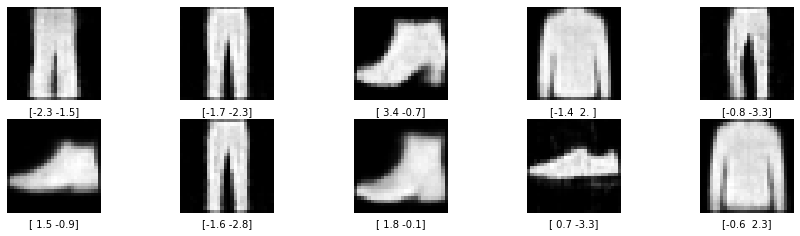

In [ ]:
figsize = 15

min_x = min(embeddings[:, 0])
max_x = max(embeddings[:, 0])
min_y = min(embeddings[:, 1])
max_y = max(embeddings[:, 1])


x = np.random.uniform(min_x,max_x, size = (10,1))
y = np.random.uniform(min_y,max_y, size = (10,1))
z_grid = np.concatenate((x,y), axis=1)
reconst = dec.predict(z_grid)


fig = plt.figure(figsize=(figsize, 10))

for i in range(10):
    ax = fig.add_subplot(5, 5, i+1)
    ax.axis('off')
    ax.text(0.5, -0.15, str(np.round(z_grid[i],1)), fontsize=10, ha='center', transform=ax.transAxes)
    
    ax.imshow(reconst[i, :,:,0]*255, cmap = 'gray')